# NLP - CS 6120 - Exploratory Data Analysis - Tweet Virality Prediction

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import textstat
import matplotlib.pyplot as plt


import re
from collections import Counter
from nltk.tokenize import word_tokenize

## Load the dataset into Dataframe

In [2]:
file_path = "dataset.csv"

In [3]:
data = pd.read_csv(file_path, low_memory=False)

In [4]:
data.head()

,url,date,content,likeCount,replyCount,retweetCount,viewCount,quoteCount,sourceLabel,links,...,vibe,username,UserDescription,UserFavouritesCount,followersCount,friendsCount,location,verified,protected,mediaCount
0,https://twitter.com/LaTera__/status/1477429429...,2022-01-01 23:59:59+00:00,I’m getting a sugar daddy this year!,0.0,10.0,0,210.006559,0,Twitter for iPhone,NaN,...,NaN,LaTera__,NCAT Alumna |🪬 | | For giggles,54402,1955,740,Michigan,False,False,2636.0
1,https://twitter.com/allirica_rose/status/14774...,2022-01-01 23:59:59+00:00,might make em french toast after and spoon a l...,1.0,0.0,0,191.910011,0,Twitter for iPhone,NaN,...,NaN,allirica_rose,"writer, reader, horror lover, general disaster...",12135,65,98,NaN,False,False,375.0
2,https://twitter.com/matrixlms/status/147742942...,2022-01-01 23:59:59+00:00,Our platform can be matched to your company’s ...,0.0,0.0,0,210.006559,0,HubSpot,"[TextLink(text='hubs.ly/Q011g-C00', url='https...",...,NaN,matrixlms,An innovative way to train and learn. \nSign u...,2145,10074,10523,"Plano, TX 75024",False,False,8275.0
3,https://twitter.com/AnarkyIsMe/status/14774294...,2022-01-01 23:59:59+00:00,Oh my God this first song. I can't with how am...,5.0,2.0,0,542.144594,0,Twitter for Android,"[TextLink(text='youtu.be/tA0-WXsm-T0', url='ht...",...,NaN,AnarkyIsMe,Vegan activist trying to make a change in the ...,8130,1507,1092,Earth 🌍,False,False,1760.0
4,https://twitter.com/__amyya/status/14774294292...,2022-01-01 23:59:59+00:00,Happy new year ! 😚🎉,1.0,0.0,0,191.910011,0,Twitter for iPhone,NaN,...,NaN,__amyya,5♥5♥5,39943,590,179,Lost in thought,False,False,625.0


## Fix datatypes for the columns

In [5]:
# Convert 'date' column to datetime and handle errors
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# After conversion, check for any NaT values that might have been introduced
print(data['date'].isnull().sum())

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

15


In [6]:
# Convert columns to numeric, handling errors by coercing invalid values to NaN
data['likeCount'] = pd.to_numeric(data['likeCount'], errors='coerce')
data['replyCount'] = pd.to_numeric(data['replyCount'], errors='coerce')
data['retweetCount'] = pd.to_numeric(data['retweetCount'], errors='coerce')
data['viewCount'] = pd.to_numeric(data['viewCount'], errors='coerce')
data['quoteCount'] = pd.to_numeric(data['quoteCount'], errors='coerce')
data['followersCount'] = pd.to_numeric(data['followersCount'], errors='coerce')
data['friendsCount'] = pd.to_numeric(data['friendsCount'], errors='coerce')
data['mediaCount'] = pd.to_numeric(data['mediaCount'], errors='coerce')
data['UserFavouritesCount'] = pd.to_numeric(data['UserFavouritesCount'], errors='coerce')


# Convert boolean-like columns to boolean
data['verified'] = data['verified'].astype(bool)
data['protected'] = data['protected'].astype(bool)


In [7]:
data.describe()

,likeCount,replyCount,retweetCount,viewCount,quoteCount,UserFavouritesCount,followersCount,friendsCount,mediaCount
count,547484.000000,547484.000000,547481.000000,5.474840e+05,547481.000000,5.474770e+05,5.474770e+05,5.474770e+05,5.474760e+05
mean,44.233178,2.186974,5.990738,3.523726e+03,0.670374,4.713569e+04,2.128300e+04,1.771146e+03,5.047063e+03
std,1371.936226,41.658713,168.566385,6.595310e+04,22.221623,7.916413e+04,4.744381e+05,8.245996e+03,7.445362e+04
min,0.000000,0.000000,0.000000,1.919100e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,0.000000,0.000000,1.919100e+02,0.000000,5.232000e+03,3.280000e+02,2.880000e+02,3.180000e+02
50%,3.000000,0.000000,0.000000,3.776185e+02,0.000000,1.958900e+04,9.490000e+02,6.490000e+02,1.196000e+03
75%,8.000000,1.000000,1.000000,9.084506e+02,0.000000,5.560400e+04,3.030000e+03,1.448000e+03,3.651000e+03
max,616020.000000,13229.000000,80815.000000,7.081089e+06,10303.000000,3.257069e+06,7.886322e+07,1.119774e+06,7.123134e+06


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547496 entries, 0 to 547495
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   url                  547484 non-null  object             
 1   date                 547481 non-null  datetime64[ns, UTC]
 2   content              547484 non-null  object             
 3   likeCount            547484 non-null  float64            
 4   replyCount           547484 non-null  float64            
 5   retweetCount         547481 non-null  float64            
 6   viewCount            547484 non-null  float64            
 7   quoteCount           547481 non-null  float64            
 8   sourceLabel          547481 non-null  object             
 9   links                54495 non-null   object             
 10  media                154208 non-null  object             
 11  quotedTweet          123546 non-null  object             
 12  me

## Handling Null Values

In [9]:
data.isnull().sum()

url                        12
date                       15
content                    12
likeCount                  12
replyCount                 12
retweetCount               15
viewCount                  12
quoteCount                 15
sourceLabel                15
links                  493001
media                  393288
quotedTweet            423950
mentionedUsers         471622
coordinates            532135
place                  532138
hashtags               460710
cashtags               544769
card                   512630
vibe                   546856
username                   12
UserDescription         30430
UserFavouritesCount        19
followersCount             19
friendsCount               19
location               135207
verified                    0
protected                   0
mediaCount                 20
dtype: int64

In [10]:
data = data.dropna(subset=['content'])
data = data.dropna(subset=['followersCount'])
data = data.dropna(subset=['friendsCount'])
data = data.dropna(subset=['mediaCount'])

In [11]:
data.isnull().sum()

url                         0
date                        0
content                     0
likeCount                   0
replyCount                  0
retweetCount                0
viewCount                   0
quoteCount                  0
sourceLabel                 0
links                  492982
media                  393270
quotedTweet            423932
mentionedUsers         471604
coordinates            532115
place                  532118
hashtags               460692
cashtags               544752
card                   512614
vibe                   546839
username                    0
UserDescription         30418
UserFavouritesCount         0
followersCount              0
friendsCount                0
location               135191
verified                    0
protected                   0
mediaCount                  0
dtype: int64

Removed rows that have no tweet text

## Distribution of the data

In [12]:
data.describe()

,likeCount,replyCount,retweetCount,viewCount,quoteCount,UserFavouritesCount,followersCount,friendsCount,mediaCount
count,547476.000000,547476.000000,547476.000000,5.474760e+05,547476.000000,5.474760e+05,5.474760e+05,5.474760e+05,5.474760e+05
mean,44.230308,2.186996,5.990781,3.523262e+03,0.670378,4.713576e+04,2.128304e+04,1.771148e+03,5.047063e+03
std,1371.944197,41.659017,168.567154,6.595259e+04,22.221724,7.916418e+04,4.744385e+05,8.246003e+03,7.445362e+04
min,0.000000,0.000000,0.000000,1.919100e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,0.000000,0.000000,1.919100e+02,0.000000,5.232000e+03,3.280000e+02,2.880000e+02,3.180000e+02
50%,3.000000,0.000000,0.000000,3.776185e+02,0.000000,1.958900e+04,9.490000e+02,6.490000e+02,1.196000e+03
75%,8.000000,1.000000,1.000000,9.084506e+02,0.000000,5.560400e+04,3.030000e+03,1.448000e+03,3.651000e+03
max,616020.000000,13229.000000,80815.000000,7.081089e+06,10303.000000,3.257069e+06,7.886322e+07,1.119774e+06,7.123134e+06


Looking at the above statistics, For likeCount the 75th percentile is 8, which means that 75% of the tweets have 8 likes or fewer.
However, the maximum value is 616020, which is extremely high compared to the 75th percentile. This indicates that there are some tweets with likes that are several orders of magnitude greater than the majority of the data.

We see similar statistics for the other user engagement metrics as well.

Tha data has a ***long tail distribution*** - most of the values are clustered at the lower end (as indicated by the median and 75th percentile), but there are a few values that are much larger than the rest.

These few large values could be potential outliers or could represent rare events (like viral tweets).

Since the goal of this project is to predict the virality, we choose to preserve the viral tweets (while not affecting the models) by splitting the virality as "High" and "Low" at the 90th percentile.

## Graphs

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
sns.set(style="whitegrid")

# List of columns to plot
engagement_metrics = ['likeCount', 'replyCount', 'retweetCount', 'viewCount']

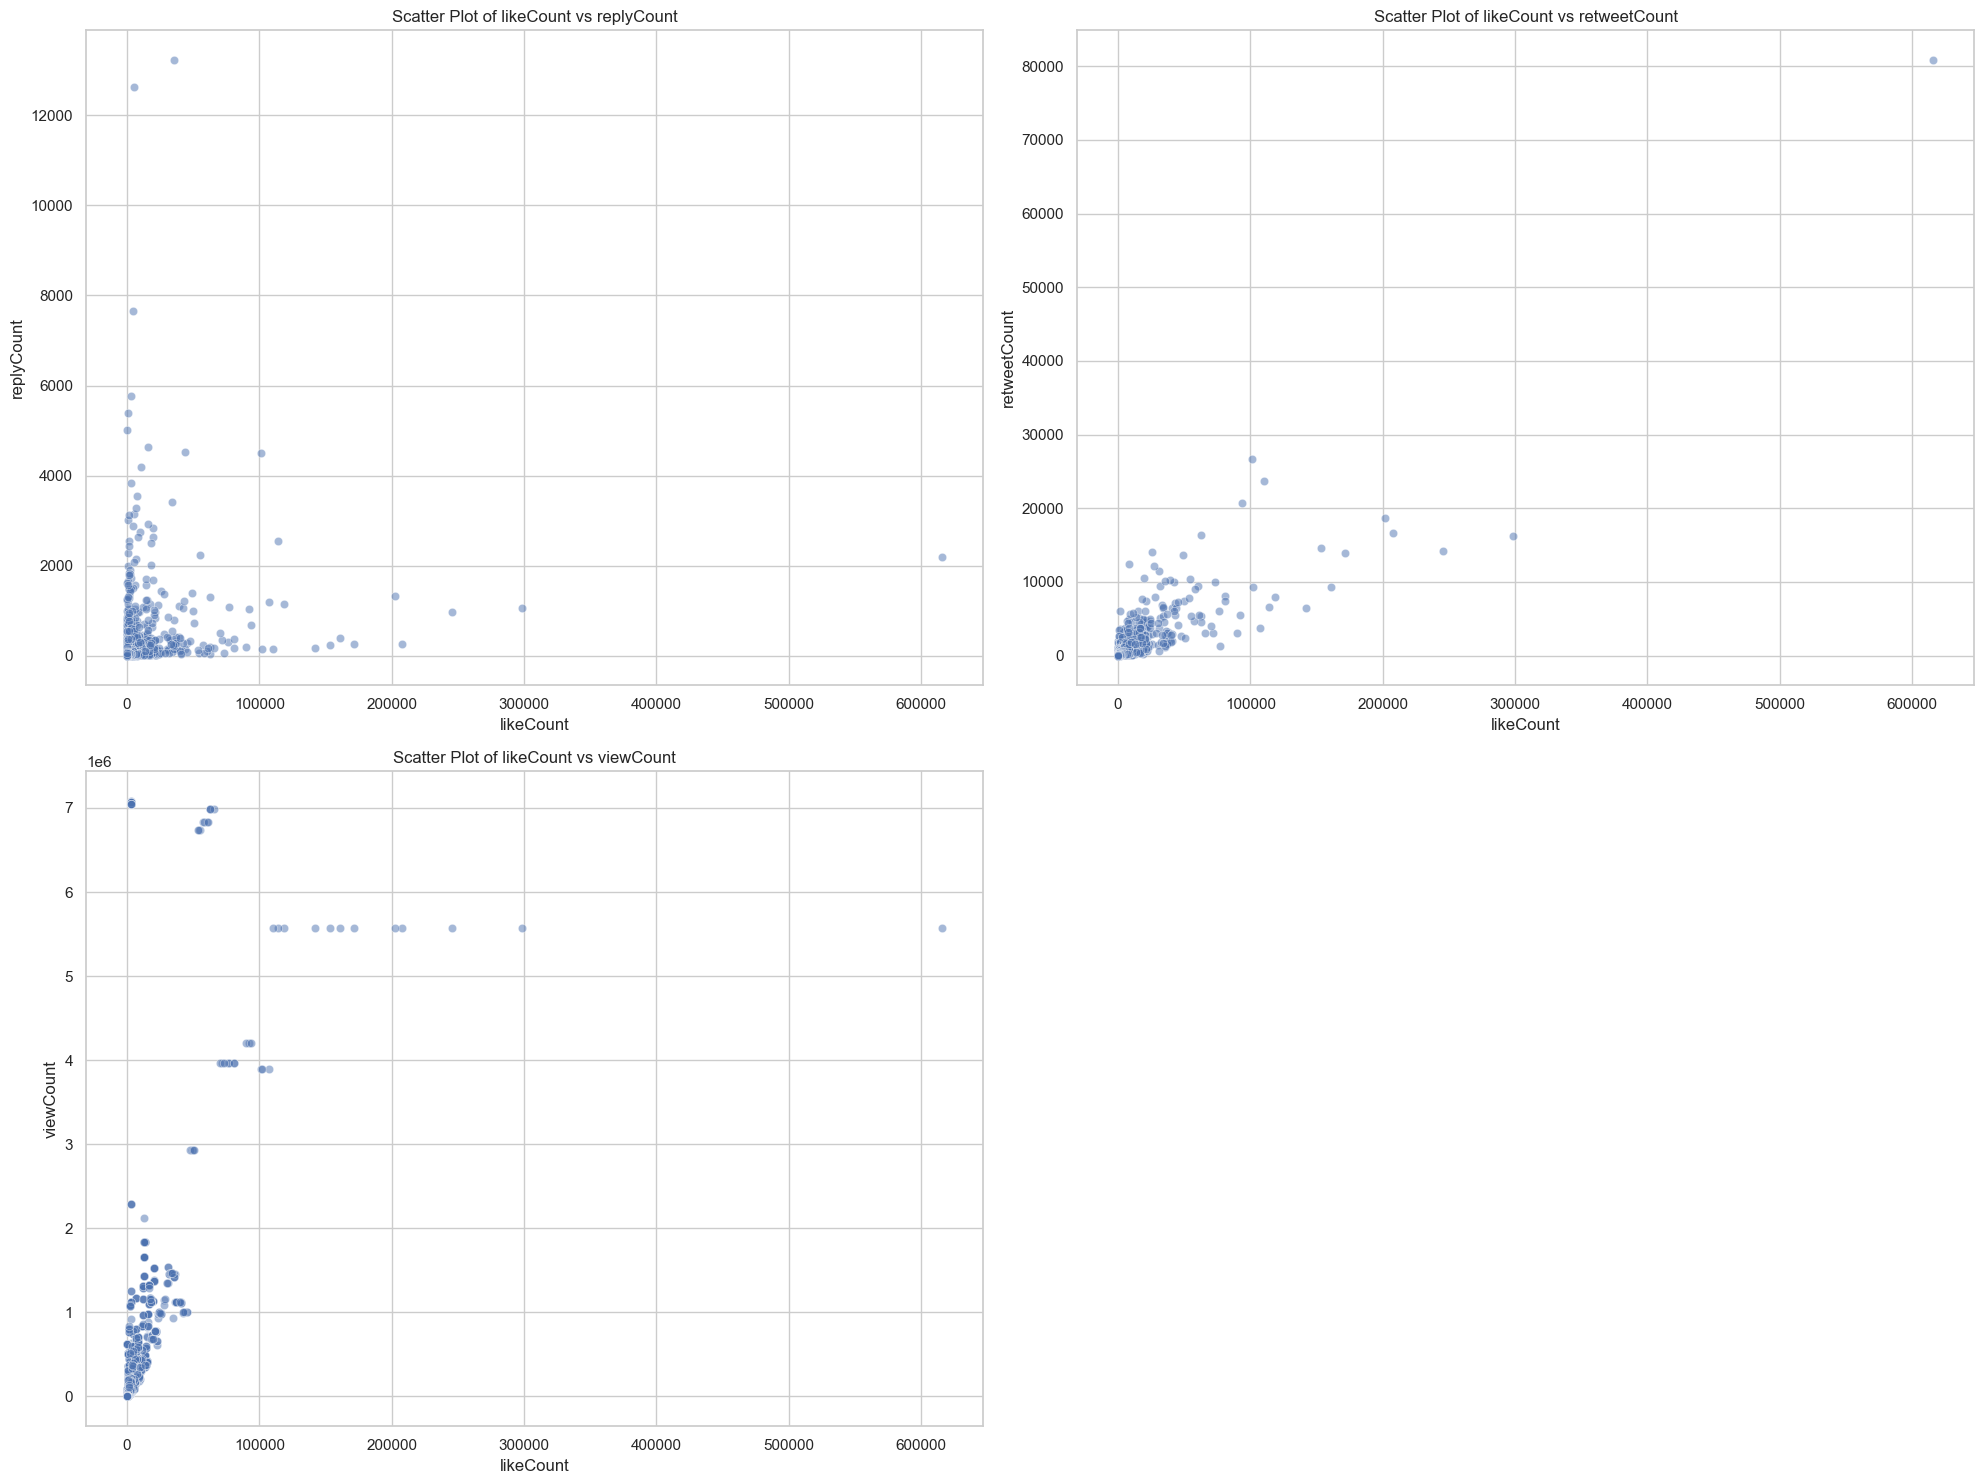

In [15]:
# Scatter Plots - comparing 'likeCount' with other engagement metrics
plt.figure(figsize=(20, 15))
for i, column in enumerate(engagement_metrics[1:], 1):  # Skip likeCount to avoid self-comparison
    plt.subplot(2, 2, i)
    sns.scatterplot(data=data, x='likeCount', y=column, alpha=0.5)
    plt.title(f'Scatter Plot of likeCount vs {column}')
    plt.xlabel('likeCount')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

### Time Series Plotting

In [16]:
# Remove rows with NaT in 'date' column
cleaned_data = data.dropna(subset=['date'])

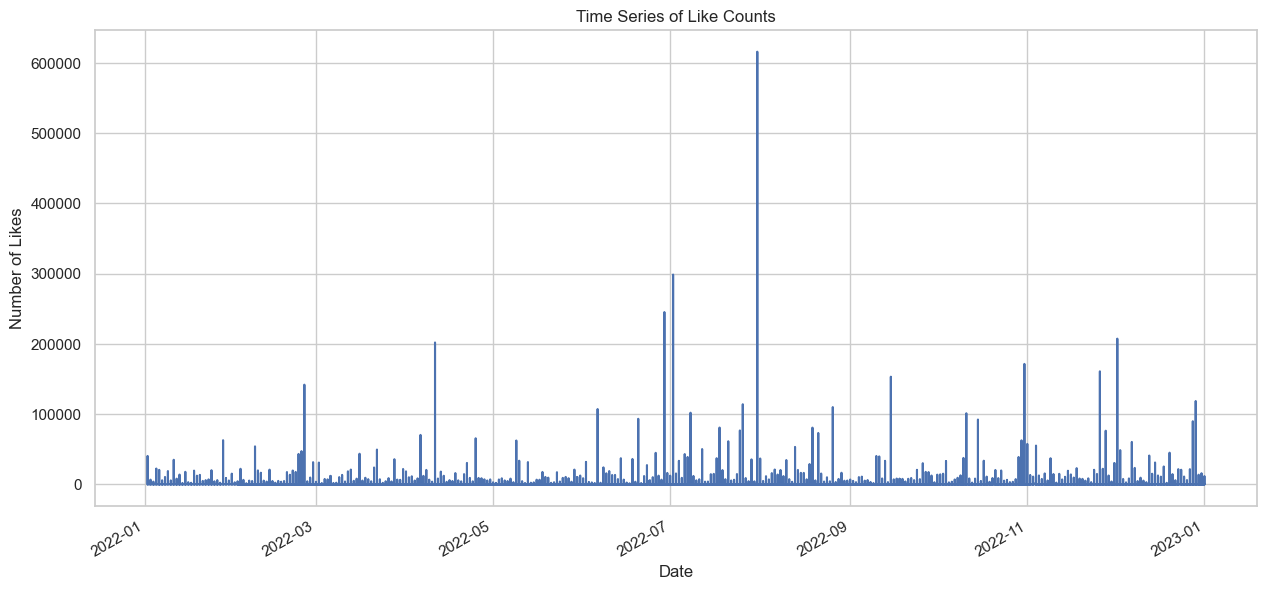

In [17]:
plt.figure(figsize=(15, 7))
cleaned_data.set_index('date')['likeCount'].plot()
plt.title('Time Series of Like Counts')
plt.xlabel('Date')
plt.ylabel('Number of Likes')
plt.show()


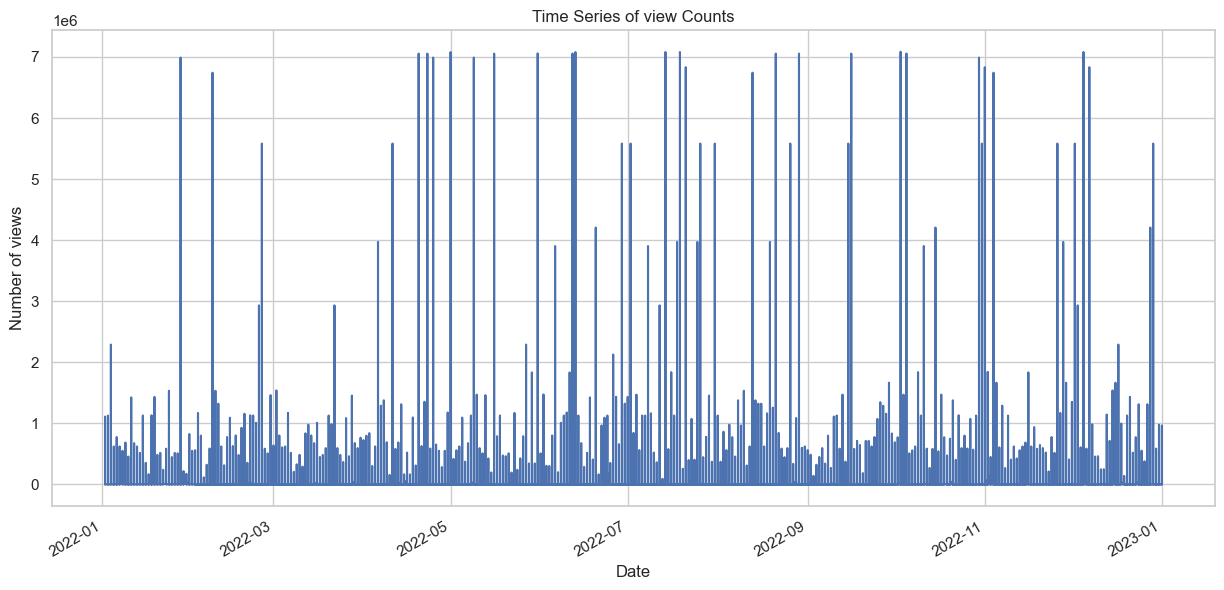

In [18]:
plt.figure(figsize=(15, 7))
cleaned_data.set_index('date')['viewCount'].plot()
plt.title('Time Series of view Counts')
plt.xlabel('Date')
plt.ylabel('Number of views')
plt.show()

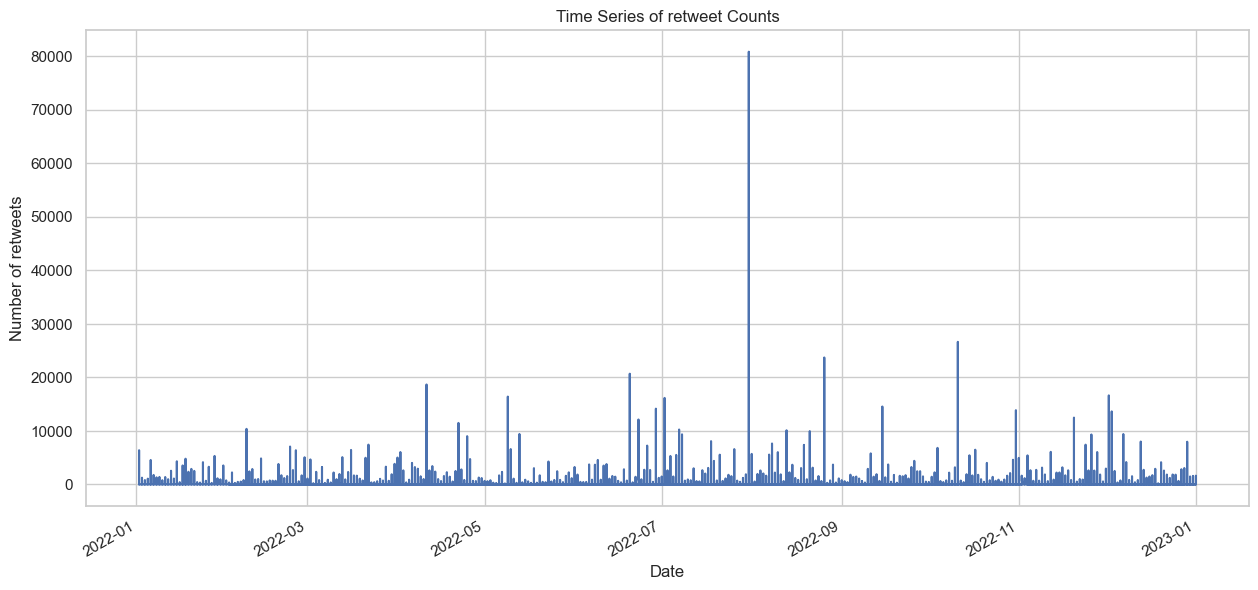

In [19]:
plt.figure(figsize=(15, 7))
cleaned_data.set_index('date')['retweetCount'].plot()
plt.title('Time Series of retweet Counts')
plt.xlabel('Date')
plt.ylabel('Number of retweets')
plt.show()

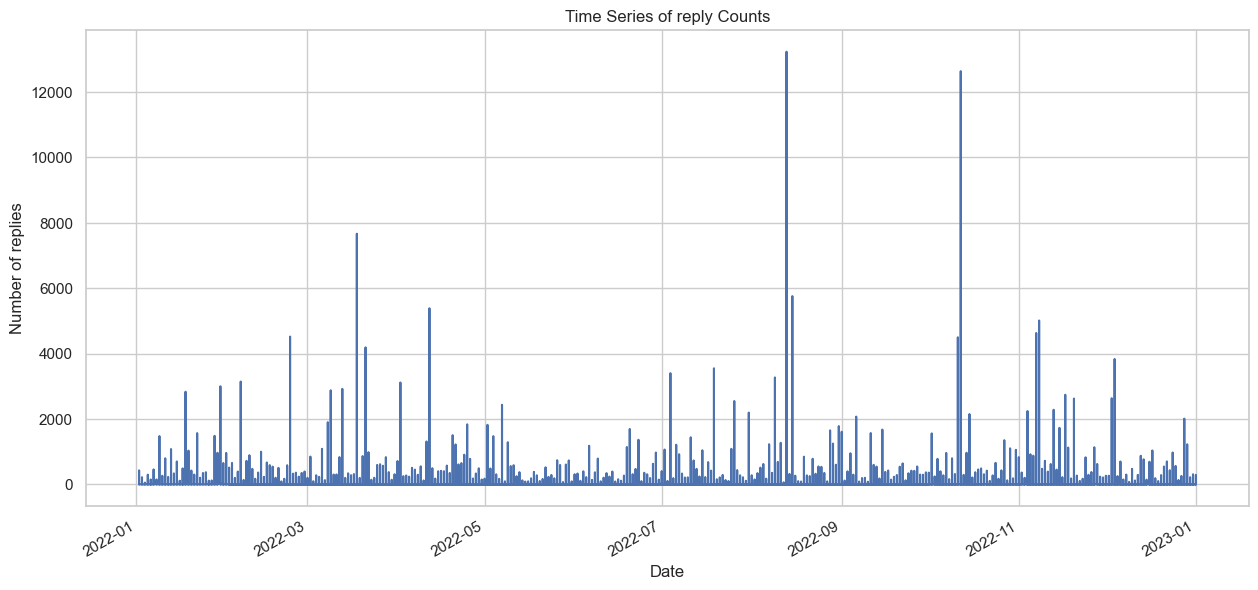

In [20]:
plt.figure(figsize=(15, 7))
cleaned_data.set_index('date')['replyCount'].plot()
plt.title('Time Series of reply Counts')
plt.xlabel('Date')
plt.ylabel('Number of replies')
plt.show()

### Readability and Correlation Matrix

In [21]:
import pandas as pd
import textstat

data['content'] = data['content'].astype(str)  # Ensuring all content is treated as string

# Function to calculate Flesch Reading Ease
def get_flesch_reading_ease(text):
    try:
        return textstat.flesch_reading_ease(text)
    except TypeError:
        return None  # Return None for texts that cause errors

# Tracking progress with print statements
flesch_scores = []
total = len(data['content'])
for index, text in enumerate(data['content']):
    if index % 100000 == 0:  # Print progress every 100,000 records
        print(f"Processing... {index}/{total} records processed.")
    score = get_flesch_reading_ease(text)
    flesch_scores.append(score)

data['flesch_reading_ease'] = flesch_scores  # Assign the scores to a new column

# Display the updated DataFrame
print("Processing completed.")
# print(data.head())

if 'likeCount' in data.columns and 'replyCount' in data.columns and 'retweetCount' in data.columns:
    correlation_matrix = data[['likeCount', 'replyCount', 'retweetCount', 'flesch_reading_ease']].corr()
    print(correlation_matrix)


Processing... 0/547476 records processed.
Processing... 100000/547476 records processed.
Processing... 200000/547476 records processed.
Processing... 300000/547476 records processed.
Processing... 400000/547476 records processed.
Processing... 500000/547476 records processed.
Processing completed.
                     likeCount  replyCount  retweetCount  flesch_reading_ease
likeCount             1.000000    0.243921      0.876895            -0.007376
replyCount            0.243921    1.000000      0.321835            -0.004170
retweetCount          0.876895    0.321835      1.000000            -0.009361
flesch_reading_ease  -0.007376   -0.004170     -0.009361             1.000000


***The Flesch Reading Ease score*** is a readability test designed to indicate how easy it is to understand a text. The score is calculated based on the length of words and sentences in the text. It ranges from 1 to 100, where higher scores indicate text that is easier to read. Texts with a score of 70-100 are considered easy to read for the average adult, while scores from 0-30 are considered difficult for most adults.

The scores show a near-zero correlation with engagement metrics (likeCount, replyCount, retweetCount). This indicates that the readability of the tweet, as measured by the Flesch Reading Ease, does not significantly influence how many likes, replies, or retweets it receives. This suggests that for Twitter content, readability may not be a critical factor in determining engagement.

**__The minimal correlation values with flesch_reading_ease suggest that the simplicity or complexity of language in tweets does not significantly impact how the tweet is engaged with. This could mean that on Twitter, content may be driven more by immediacy, relevance, and emotional impact rather than how easy it is to read.__**

***Correlation Values and Interpretations :***

likeCount and retweetCount (0.876895): This high positive correlation indicates that tweets that receive a lot of likes also tend to get a lot of retweets. This is logical since both metrics are measures of positive engagement and popularity.

likeCount and replyCount (0.243921): This moderate positive correlation suggests that tweets with more likes also tend to have more replies. 

replyCount and retweetCount (0.321835): A moderate positive correlation exists here, implying that tweets that prompt more replies also tend to get retweeted more often.

**__The strong correlation between likes and retweets underscores typical user behavior on Twitter. The moderate correlations involving replies indicate that while replies are a form of engagement, they are less predictable based on likes or retweets alone.__**

### Locations and Tweet Count

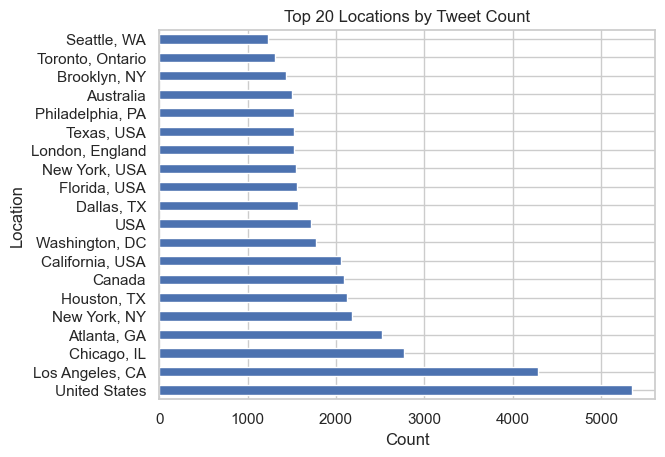

In [22]:
non_location_terms = ['she/her', 'he/him', 'they/them']

# Filter out non-location terms
data['location'] = data['location'].apply(lambda x: None if x in non_location_terms else x)

# Now plot the top 20 locations by tweet count
top_locations = data['location'].value_counts().head(20)
top_locations.plot(kind='barh')
plt.title('Top 20 Locations by Tweet Count')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

The chart indicates that the majority of the tweets in the dataset come from users located in urban and metropolitan areas, with places like New York and Los Angeles.

Content can be tailored to the cultural context or time zones of these locations for better engagement.

### Distribution of Virality Score

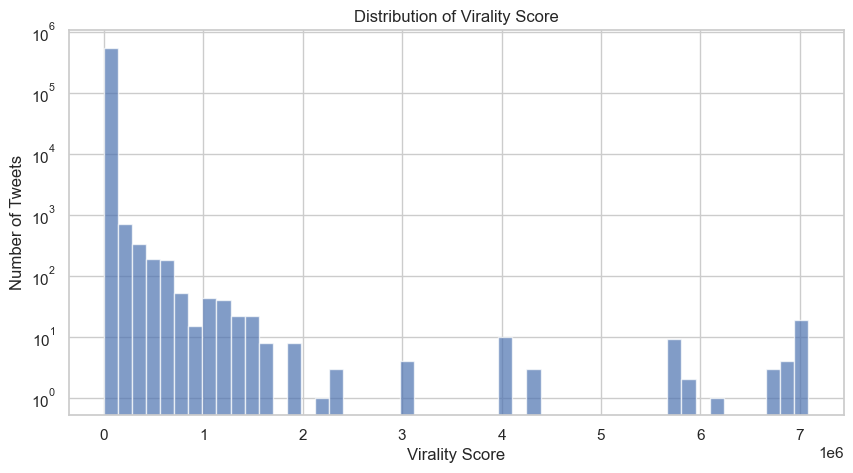

In [23]:
# Create a new column for virality score
data['virality_score'] = data['likeCount'] + data['replyCount'] + data['viewCount']

# Plot the virality score
plt.figure(figsize=(10, 5))
plt.hist(data['virality_score'], bins=50, alpha=0.7)
plt.title('Distribution of Virality Score')
plt.xlabel('Virality Score')
plt.ylabel('Number of Tweets')
plt.yscale('log')  # Using a log scale can help visualize a long-tail distribution
plt.grid(True)
plt.show()

The graph clearly shows a long-tail distribution. Most tweets have a low virality score, indicating that they receive a relatively low number of likes, replies, and views. This is expected in twitter datasets, A large number of posts have minimal engagement, and only a few posts achieve very high engagement.

There are very few tweets with high virality scores. This underscores the rarity of viral content and suggests that tweets that achieve high engagement are outliers compared to the typical post.

### Media and Virality

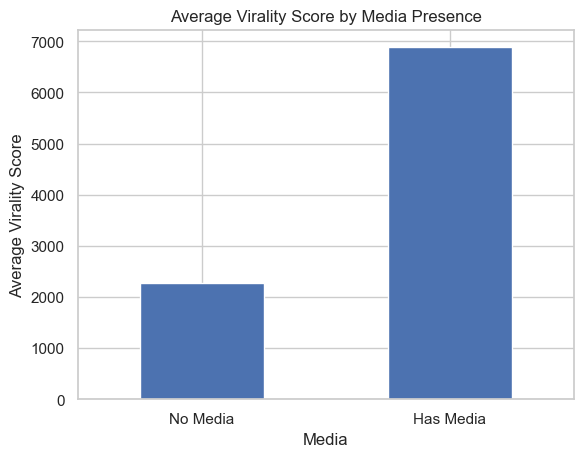

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Determine if a tweet has media
data['has_media'] = ~data['media'].isna()

# Group by the 'has_media' column and calculate the mean virality score for each group
grouped_data = data.groupby('has_media')['virality_score'].mean()

# Plot the comparison as a bar chart
grouped_data.plot(kind='bar')
plt.title('Average Virality Score by Media Presence')
plt.xlabel('Media')
plt.ylabel('Average Virality Score')
plt.xticks(ticks=[0, 1], labels=['No Media', 'Has Media'], rotation=0)  
plt.show()

Media elements in tweets, on average, appear to attract more engagement, leading to higher virality scores. This could be because visual or multimedia content is more engaging or shareable.

### Verified and Virality

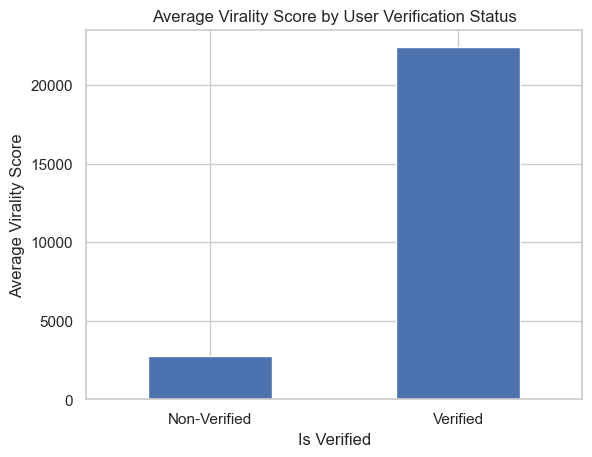

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'verified' status and calculate the average 'virality_score' for each group
avg_virality_by_verification = data.groupby('verified')['virality_score'].mean()

# Plot the comparison as a bar chart
avg_virality_by_verification.plot(kind='bar')
plt.title('Average Virality Score by User Verification Status')
plt.xlabel('Is Verified')
plt.ylabel('Average Virality Score')
plt.xticks(ticks=[0, 1], labels=['Non-Verified', 'Verified'], rotation=0)
plt.show()


Verification on Twitter signifies that an account is of public interest and tends to be authentic and influential. The higher average virality score for verified accounts suggests that tweets from these accounts are more likely to gain significant engagement. The above graph is as per the expectation and aligns with the idea of the tweet going viral when tweeted by celebrities or famous people.

### Like Count Distribution

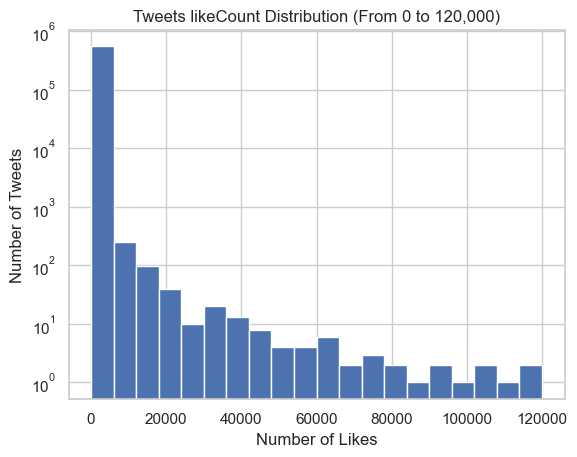

In [26]:
data['likeCount'].hist(range=(0,120000), log=True, bins=20) 
plt.title('Tweets likeCount Distribution (From 0 to 120,000)')
plt.xlabel('Number of Likes')
plt.ylabel('Number of Tweets')
plt.show()